In [1]:

import glob
import matplotlib.pyplot as plt
import numpy as np
import pickle

from COCOWrapper import COCOWrapper
from Plot import F1


In [2]:

root='/home/gregory/Datasets/COCO'
year='2017'

main_classes = ['snowboard', 'couch', 'tie', 'handbag', 'skis', 'remote', 'toothbrush', 'sports ball', 'knife', 'cell phone', 'fork', 'wine glass', 'skateboard', 'spoon', 'backpack', 'bench', 'frisbee']
spurious_class = 'person'

comparisons =  ['random-tune', 'random-tune-paint']
baseline = 'initial-tune'

models = [model for model in comparisons]
models.insert(0, baseline)

datafiles = []
datafiles.append('{}/train{}-with-{}-info.p'.format(root, year, spurious_class))
datafiles.append('{}/train{}-without-{}-info.p'.format(root, year, spurious_class))
datafiles.append('{}/val{}-{}-info.p'.format(root, year, spurious_class))

coco = COCOWrapper(root = root, mode = 'val', year = year)


loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [3]:
def collect(model, datafile):

    p = []
    r = []

    for main_class in main_classes:        
        index = coco.get_cat_ids(main_class)[0]
        
        p_tmp = []
        r_tmp = []
        
        for file in glob.glob('./Models/{}/*.p'.format(model)):
            with open(file, 'rb') as f:
                data = pickle.load(f)
                
            data = data[datafile]
            p_tmp.append(data[0][index])
            r_tmp.append(data[1][index])
            
        p.append(np.mean(p_tmp))
        r.append(np.mean(r_tmp))

    return np.array(p), np.array(r)

        
def compare(comparisons, baseline, datafile, title):  
    
    plt.axhline(0, color='black', linestyle = '--')
    plt.axvline(0, color='black', linestyle = '--')
    
    plt.ylabel('Change in Recall')
    plt.xlabel('Change in Precision')
    
    plt.title('Comparison to {}: {}'.format(baseline, title))
    
    p_base, r_base = collect(baseline, datafile)
    
    for comparison in comparisons:
        p_comp, r_comp = collect(comparison, datafile)

        p_diff = p_comp - p_base
        r_diff = r_comp - r_base

        plt.scatter(p_diff, r_diff, label = comparison)

    plt.legend()
    plt.show()
    plt.close()

def collect_gap(datafile1, datafile2, model):
    
    p = []
    r = []

    for main_class in main_classes:        
        index = coco.get_cat_ids(main_class)[0]
        
        p_tmp = []
        r_tmp = []
        
        for file in glob.glob('./Models/{}/*.p'.format(model)):
            with open(file, 'rb') as f:
                data = pickle.load(f)
                
            data1 = data[datafile1]
            data2 = data[datafile2]
            
            p_tmp.append(data1[0][index] - data2[0][index])
            r_tmp.append(data1[1][index] - data2[1][index])
            
        p.append(np.mean(p_tmp))
        r.append(np.mean(r_tmp))

    return np.array(p), np.array(r)

def compare_gap(models, datafile1, datafile2, spurious_class):  
    
    plt.axhline(0, color='black', linestyle = '--')
    plt.axvline(0, color='black', linestyle = '--')
    
    plt.ylabel('Recall Gap')
    plt.xlabel('Precision Gap')
    
    plt.title('Performance Gap between Images without and with {}'.format(spurious_class))
    
    for model in models:
        p, r = collect_gap(datafile1, datafile2, model)

        plt.scatter(p, r, label = model)

    plt.legend()    
    plt.show()
    plt.close()
    
def collect_F1(model, datafile):

    F = []

    for main_class in main_classes:        
        index = coco.get_cat_ids(main_class)[0]
        
        p_tmp = []
        r_tmp = []
        
        for file in glob.glob('./Models/{}/*.p'.format(model)):
            with open(file, 'rb') as f:
                data = pickle.load(f)
                
            data = data[datafile]
            p_tmp.append(data[0][index])
            r_tmp.append(data[1][index])
            
        F.append(np.mean(F1(p_tmp, r_tmp)))

    return np.array(F)

def compare_F1(comparisons, baseline, datafile, title):  
    
    f_base = collect_F1(baseline, datafile)
    
    out = {}
    for comparison in comparisons:
        f = collect_F1(comparison, datafile)
        diff = f - f_base
        out[comparison] = diff
    
    fig, ax = plt.subplots()
    plt.title('Comparison to {}: {}'.format(baseline, title))
    ax.boxplot(out.values())
    ax.set_xticklabels(out.keys())

In [4]:
%matplotlib inline


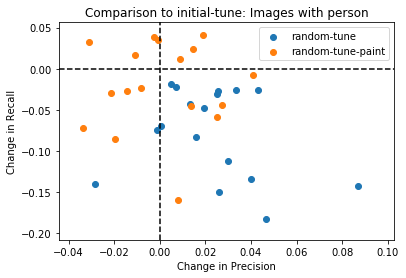

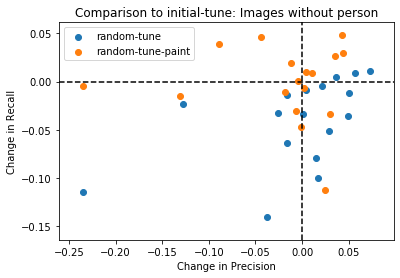

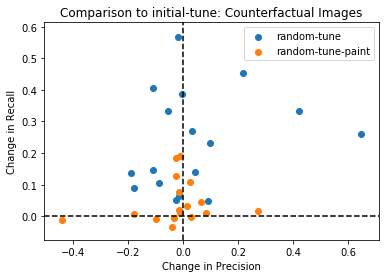

In [5]:
compare(comparisons, baseline, datafiles[0], 'Images with {}'.format(spurious_class)) 
compare(comparisons, baseline, datafiles[1], 'Images without {}'.format(spurious_class))    
compare(comparisons, baseline, datafiles[2], 'Masked Images')   


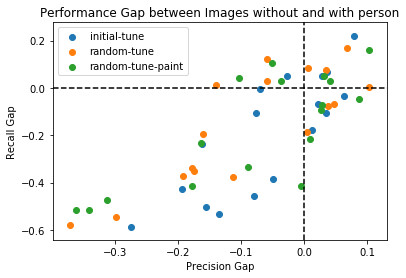

In [6]:
compare_gap(models, datafiles[1], datafiles[0], spurious_class)


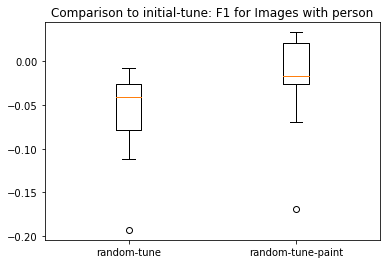

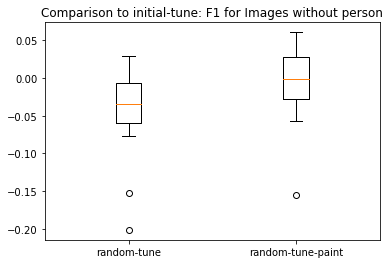

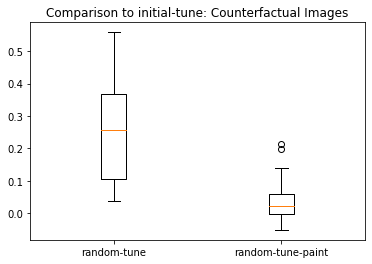

In [7]:
compare_F1(comparisons, baseline, datafiles[0], 'F1 for Images with {}'.format(spurious_class))
compare_F1(comparisons, baseline, datafiles[1], 'F1 for Images without {}'.format(spurious_class))
compare_F1(comparisons, baseline, datafiles[2], 'Masked Images')



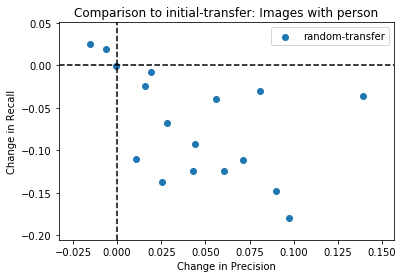

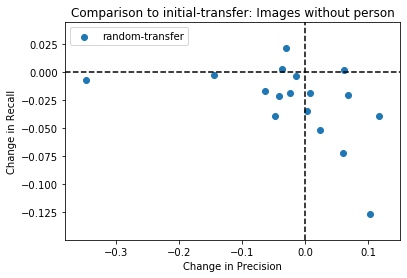

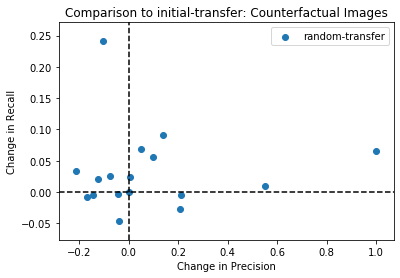

In [8]:
compare(['random-transfer'], 'initial-transfer', datafiles[0], 'Images with {}'.format(spurious_class)) 
compare(['random-transfer'], 'initial-transfer', datafiles[1], 'Images without {}'.format(spurious_class))    
compare(['random-transfer'], 'initial-transfer', datafiles[2], 'Masked Images')    


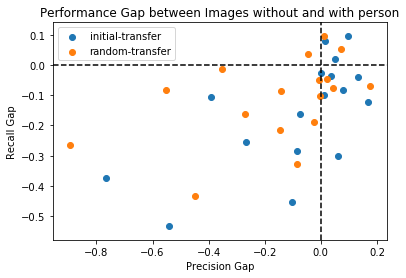

In [9]:
compare_gap(['initial-transfer', 'random-transfer'], datafiles[1], datafiles[0], spurious_class)

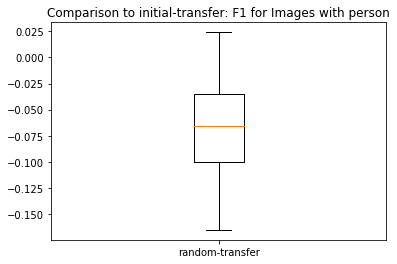

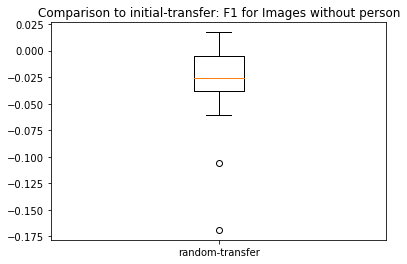

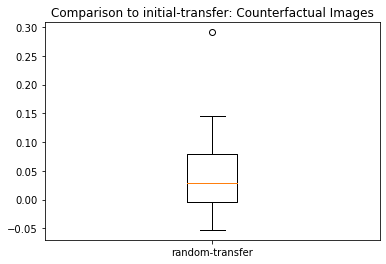

In [10]:
compare_F1(['random-transfer'], 'initial-transfer', datafiles[0], 'F1 for Images with {}'.format(spurious_class))
compare_F1(['random-transfer'], 'initial-transfer', datafiles[1], 'F1 for Images without {}'.format(spurious_class))
compare_F1(['random-transfer'], 'initial-transfer', datafiles[2], 'Masked Images')

